In [ ]:
from utilities import *

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,  RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import resample


In [2]:
#X,y = create_features_matrix(dataset, category=True, save=True)
X = np.load("saves/train_features.npy")
y = np.load("saves/categories.npy")
print(f"Number of features: {X.shape[1]}")

Number of features: 47


In [ ]:
param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

rf = RandomForestClassifier(random_state=0)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=50, cv=cv, scoring="accuracy", 
    n_jobs=-1, random_state=42, return_train_score=True
)

random_search.fit(X, y)

print("Best params found :", random_search.best_params_)

best_index = random_search.best_index_
mean_val_score = random_search.cv_results_['mean_test_score'][best_index]
std_val_score = random_search.cv_results_['std_test_score'][best_index]

print(f"Validation Accuracy: {mean_val_score:.3f} ± {std_val_score:.3f}")

mean_train_score = random_search.cv_results_['mean_train_score'][best_index]
std_train_score = random_search.cv_results_['std_train_score'][best_index]

print(f"Train Accuracy: {mean_train_score:.3f} ± {std_train_score:.3f}")


Meilleurs paramètres trouvés : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 395}
Validation Accuracy: 0.940 ± 0.037
Train Accuracy: 0.989 ± 0.006


In [5]:
clf = RandomForestClassifier(**random_search.best_params_, random_state=0)
clf.fit(X, y)
print(clf.score(X, y))

0.99


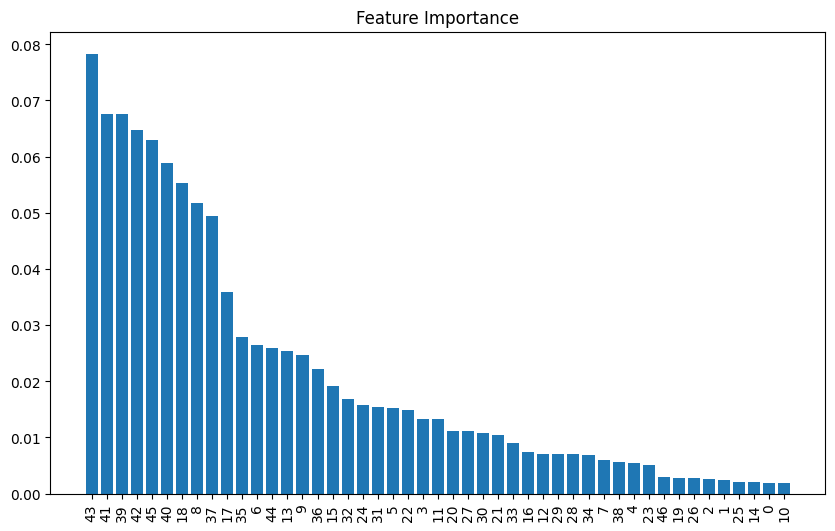

In [6]:
importances = clf.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

In [11]:
X_filtered, removed_features = filter_features(X, importances, threshold=0.01)

19 features deleted on 47


In [ ]:
param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=50, cv=cv, scoring="accuracy", 
    n_jobs=-1, random_state=42, return_train_score=True
)

random_search.fit(X_filtered, y)

print("Meilleurs paramètres trouvés :", random_search.best_params_)

best_index = random_search.best_index_
mean_val_score = random_search.cv_results_['mean_test_score'][best_index]
std_val_score = random_search.cv_results_['std_test_score'][best_index]

print(f"Validation Accuracy: {mean_val_score:.3f} ± {std_val_score:.3f}")

mean_train_score = random_search.cv_results_['mean_train_score'][best_index]
std_train_score = random_search.cv_results_['std_train_score'][best_index]

print(f"Train Accuracy: {mean_train_score:.3f} ± {std_train_score:.3f}")

Meilleurs paramètres trouvés : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 200}
Validation Accuracy: 0.943 ± 0.025
Train Accuracy: 0.977 ± 0.005


In [ ]:
clf_filtered = RandomForestClassifier(**random_search.best_params_, random_state=0)
clf_filtered.fit(X_filtered, y)
print(clf_filtered.score(X_filtered, y))

0.97


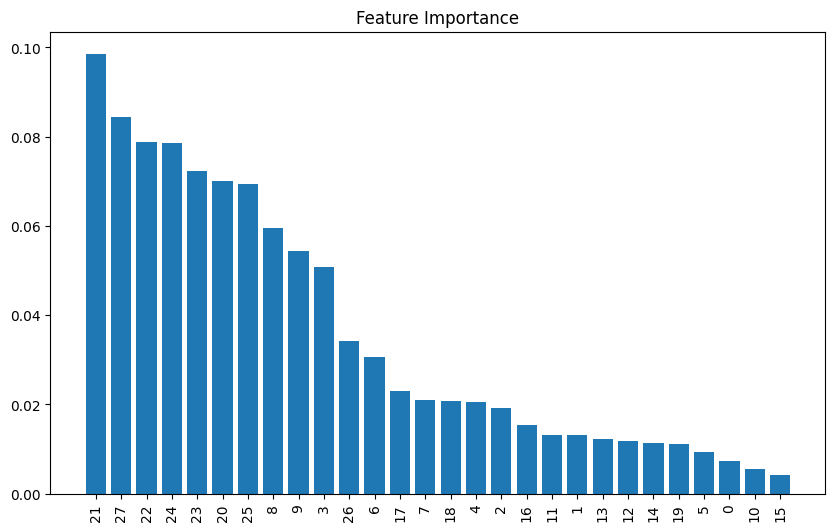

In [ ]:
importances = clf_filtered.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

In [ ]:
N_SIMULATIONS = 1000
sample_size = int(0.3 * len(y))

bootstrap_scores = []
for _ in range(N_SIMULATIONS):
    X_sample, y_sample = resample(X_filtered, y, n_samples=sample_size, random_state=None)
    bootstrap_scores.append(clf_filtered.score(X_sample, y_sample))

print(f"Bootstrapped Validation Score: {np.mean(bootstrap_scores):.3f} ± {np.std(bootstrap_scores):.3f}")

Bootstrapped Validation Score: 0.979 ± 0.025


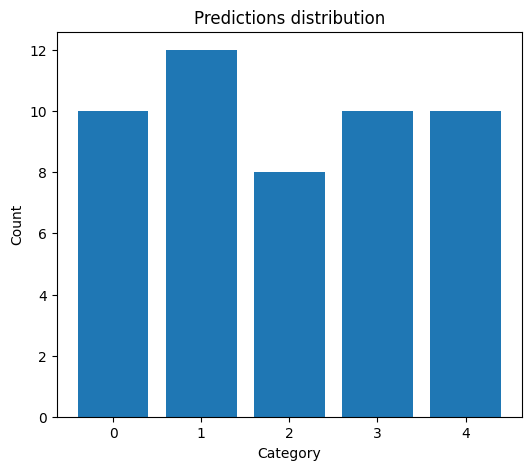

Submission file submission.csv created


In [ ]:
submission(clf_filtered, "submission", removed_features=removed_features)